In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from time import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import optuna
from optuna.samplers import TPESampler
 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor


df = pd.read_csv('MiningProcess_Flotation_Plant_Database.csv', decimal=',')
df.drop(['date'], axis=1, inplace=True) 
pd.options.display.max_columns = None
display(df)

import warnings
warnings.filterwarnings("ignore")


,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,55.20,16.98,3019.53,557.434,395.713,10.06640,1.74000,249.214,253.235,250.576,295.096,306.400,250.225,250.884,457.396,432.962,424.954,443.558,502.255,446.370,523.344,66.91,1.31
1,55.20,16.98,3024.41,563.965,397.383,10.06720,1.74000,249.719,250.532,250.862,295.096,306.400,250.137,248.994,451.891,429.560,432.939,448.086,496.363,445.922,498.075,66.91,1.31
2,55.20,16.98,3043.46,568.054,399.668,10.06800,1.74000,249.741,247.874,250.313,295.096,306.400,251.345,248.071,451.240,468.927,434.610,449.688,484.411,447.826,458.567,66.91,1.31
3,55.20,16.98,3047.36,568.665,397.939,10.06890,1.74000,249.917,254.487,250.049,295.096,306.400,250.422,251.147,452.441,458.165,442.865,446.210,471.411,437.690,427.669,66.91,1.31
4,55.20,16.98,3033.69,558.167,400.254,10.06970,1.74000,250.203,252.136,249.895,295.096,306.400,249.983,248.928,452.441,452.900,450.523,453.670,462.598,443.682,425.679,66.91,1.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
737448,49.75,23.20,2710.94,441.052,386.570,9.62129,1.65365,302.344,298.786,299.163,299.920,299.623,346.794,313.695,392.160,430.702,872.008,418.725,497.548,446.357,416.892,64.27,1.71
737449,49.75,23.20,2692.01,473.436,384.939,9.62063,1.65352,303.013,301.879,299.487,299.710,300.465,330.023,236.700,401.505,404.616,864.409,418.377,506.398,372.995,426.337,64.27,1.71
737450,49.75,23.20,2692.20,500.488,383.496,9.61874,1.65338,303.662,307.397,299.487,299.927,299.707,329.590,225.879,408.899,399.316,867.598,419.531,503.414,336.035,433.130,64.27,1.71
737451,49.75,23.20,1164.12,491.548,384.976,9.61686,1.65324,302.550,301.959,298.045,299.372,298.819,351.453,308.115,405.107,466.832,876.591,407.299,502.301,340.844,433.966,64.27,1.71


In [4]:
#Since the dataset have an extremely large sample (73k samples), only 1500 subsamples will be randomly sampled and processed to decrease run time and memory usage. 
df_sample = df.sample(n=1500,random_state =0, replace = False)


# Filtering target classes with less than 2 unique values
def filter_classes(df_sample, min_samples=2):
    class_counts = df_sample['% Silica Concentrate'].value_counts()
    filtered_labels = class_counts[class_counts >= min_samples].index
    filtered_df = df_sample[df_sample['% Silica Concentrate'].isin(filtered_labels)]
    return filtered_df
df_filtered = filter_classes(df_sample)

display(df_filtered)

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
525873,58.08,10.16,4053.200000,625.898000,402.255000,9.41017,1.717090,250.056,249.992,251.367,298.029676,296.207680,253.293,245.3590,414.132,406.638000,400.914,499.431,471.789000,507.912,499.280000,66.89,2.13
440812,55.79,15.52,3556.860000,614.892000,401.253000,9.68512,1.741970,298.930,292.301,296.872,298.212000,297.403000,297.140,316.2290,392.737,411.487000,404.375,383.481,394.253000,401.374,378.318000,64.80,1.60
606689,48.81,25.31,3642.943750,559.026000,378.583000,9.85714,1.712060,299.657,294.834,299.967,304.278260,299.257027,347.504,351.2230,520.847,497.634000,498.422,348.939,351.122000,397.668,383.318000,65.48,1.72
449866,50.70,22.76,3552.730000,550.026000,399.167000,10.25950,1.678300,298.828,297.991,300.402,298.895000,301.868000,296.412,285.0850,399.227,558.041000,428.715,659.682,215.695476,407.905,411.428000,65.99,1.30
267346,64.03,6.26,963.154235,444.946000,400.488000,10.03460,1.709150,299.927,293.555,298.828,300.146000,297.070000,300.806,301.6850,449.939,460.488000,449.985,404.297,383.344000,402.682,359.194000,65.73,1.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205934,52.61,20.24,616.875668,244.497539,400.093000,9.07594,1.520565,250.100,252.200,248.899,300.121000,300.019000,299.319,302.4560,445.749,439.216000,446.736,340.661,351.693000,350.857,324.408000,64.96,2.40
516447,55.73,14.36,3659.971250,577.614000,401.978000,10.56070,1.695190,300.450,297.832,298.203,301.393000,299.669000,295.604,305.4050,401.831,804.889017,406.812,401.759,413.067000,175.096,638.232197,66.13,1.32
291105,64.03,6.26,3494.300000,506.894000,406.216000,9.88681,1.687710,299.295,295.740,298.774,299.487000,302.650000,305.064,301.2770,615.815,580.764000,596.452,486.100,534.461000,481.537,453.843000,66.67,1.16
395268,49.93,22.49,1025.535793,591.796000,402.889000,9.52588,1.720420,300.059,294.655,298.872,300.234000,302.607000,307.837,297.8620,401.591,410.304000,400.780,392.185,395.354000,384.742,391.749000,66.89,1.04


In [5]:
# Separate the X data (22 feature columns) from the y data (G3). 
y = df_filtered['% Silica Concentrate'].to_numpy().reshape(-1,1) 
X = df_filtered.iloc[:,0:22].to_numpy()

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y,random_state=0)

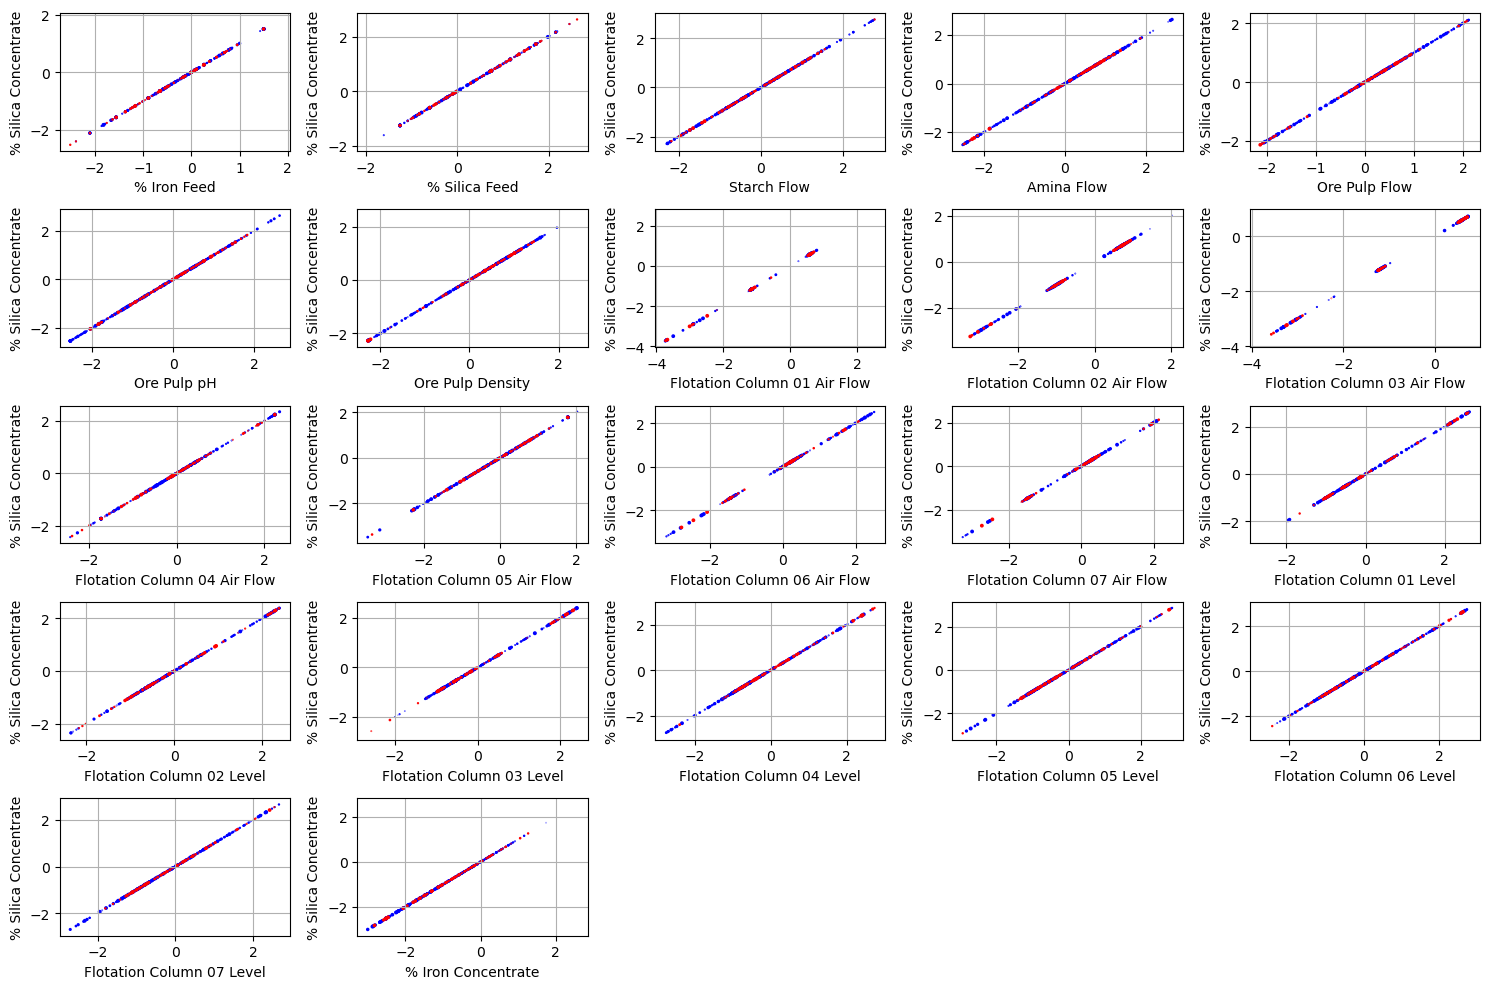

In [6]:
# Normalize Data
y_train, y_test = y_train.reshape(-1,1), y_test.reshape(-1,1)
scaler_X,scaler_Y  = StandardScaler(), StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_Y.fit_transform(y_train)
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_Y.transform(y_test)

name = list(df_sample)

#Visualize Data
plt.figure(figsize=(15,10))
for i in range(len(df_sample.columns)-1):
    plt.subplot(5,5,i+1)
    plt.scatter(X_train_scaled[:,i], X_train_scaled[:,i], y_train_scaled, c='b')
    plt.scatter(X_test_scaled[:,i], X_test_scaled[:,i], y_test_scaled, c='r')
    plt.xlabel(name[i])
    plt.ylabel('% Silica Concentrate')
    plt.grid()

plt.tight_layout()
plt.show()

In [7]:
def create_model(trial, model_type):

    if model_type == 'MLP':
        params = {
                    'learning_rate_init': trial.suggest_float('learning_rate_init ', 0.0001, 0.1, log=True),
                    'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'invscaling', 'adaptive']),
                    'first_layer_neurons': trial.suggest_int('first_layer_neurons', 10, 100, step=1),
                    'second_layer_neurons': trial.suggest_int('second_layer_neurons', 10, 100, step=1),
                    'activation': trial.suggest_categorical('activation', ['identity', 'tanh', 'relu']),
                    'alpha': trial.suggest_float('alpha', 0.0001, 1, log=True)
                 }

        model = MLPRegressor(hidden_layer_sizes=(params['first_layer_neurons'], 
                                                 params['second_layer_neurons']),
                             learning_rate_init=params['learning_rate_init'],
                             learning_rate=params['learning_rate'],
                             activation=params['activation'],
                             alpha=params['alpha'],
                             max_iter=500,
                             random_state=42)
    
        
    if model_type == 'RF':
        n_estimators = trial.suggest_int('RF_n_estimators',10,200)
        max_depth = trial.suggest_int('RF_max_depth',1,50)
        min_samples_leaf = trial.suggest_int('RF_min_samples_leaf',1,10)
        min_samples_split = trial.suggest_int('RF_min_samples_split',2,10)
        crit = trial.suggest_categorical('RF_criterion', ['friedman_mse', 'squared_error', 'absolute_error'])
        model = RandomForestRegressor(n_estimators=n_estimators, 
                                      criterion=crit, 
                                      max_depth=max_depth,
                                      min_samples_leaf=min_samples_leaf,
                                      min_samples_split=min_samples_split,
                                      random_state=42)
        
    if model_type == 'GBR':
        n_estimators = trial.suggest_int('GBR_n_estimators',10,200)
        max_depth = trial.suggest_int('GBR_max_depth',1,50)
        min_samples_leaf = trial.suggest_int('GBR_min_samples_leaf',1,10)
        min_samples_split = trial.suggest_int('GBR_min_samples_split',2,10)
        learning_rate = trial.suggest_float('GBR_learning_rate', 0.01, 0.1, log=True)
        model = GradientBoostingRegressor(n_estimators=n_estimators, 
                                          max_depth=max_depth,
                                          learning_rate=learning_rate,
                                          min_samples_leaf=min_samples_leaf,
                                          min_samples_split=min_samples_split)
        
    if model_type == 'LR':
        model = LinearRegression() # No hyperparameters to tune for Linear Regression
    
    if trial.should_prune():
            raise optuna.TrialPruned()

    return model

def objective(trial, model_type):
    model = create_model(trial, model_type)
    scores = cross_val_score(model, X_train_scaled, y_train_scaled.ravel(), 
                             cv=5, scoring='r2')
    return np.mean(scores)

sampler = TPESampler(seed=42)
best_mdls = []
studies = []

for model_type in ['MLP','RF', 'GBR','LR',]:
    study = optuna.create_study(direction='maximize', 
                                sampler=sampler)
    optuna_start = time()
    study.optimize(lambda trial: objective(trial, model_type), n_trials=100)
    studies.append(study)
    best_params = study.best_params
    print("\n\nBest parameters: ", best_params)
    total_time = time()-optuna_start
    print("Runtime: %.4f sec" % total_time)
    best_mdls.append(create_model(study.best_trial, model_type))

[I 2024-06-13 16:23:59,259] A new study created in memory with name: no-name-71222b29-6744-4eef-96b0-46220f971979
[I 2024-06-13 16:24:10,024] Trial 0 finished with value: 0.6009826376335152 and parameters: {'learning_rate_init ': 0.0013292918943162175, 'learning_rate': 'constant', 'first_layer_neurons': 24, 'second_layer_neurons': 24, 'activation': 'tanh', 'alpha': 0.06796578090758151}. Best is trial 0 with value: 0.6009826376335152.
[I 2024-06-13 16:24:21,741] Trial 1 finished with value: 0.638346201424195 and parameters: {'learning_rate_init ': 0.00011527987128232407, 'learning_rate': 'constant', 'first_layer_neurons': 26, 'second_layer_neurons': 26, 'activation': 'tanh', 'alpha': 0.0014618962793704966}. Best is trial 1 with value: 0.638346201424195.
[I 2024-06-13 16:24:25,232] Trial 2 finished with value: 0.5893748422197097 and parameters: {'learning_rate_init ': 0.006847920095574782, 'learning_rate': 'adaptive', 'first_layer_neurons': 51, 'second_layer_neurons': 81, 'activation': '

[I 2024-06-13 16:27:48,645] Trial 25 finished with value: 0.6647602080124807 and parameters: {'learning_rate_init ': 0.00635099504009941, 'learning_rate': 'invscaling', 'first_layer_neurons': 57, 'second_layer_neurons': 51, 'activation': 'tanh', 'alpha': 0.22612483700668842}. Best is trial 12 with value: 0.6918904596806862.
[I 2024-06-13 16:27:55,169] Trial 26 finished with value: 0.6020932825841635 and parameters: {'learning_rate_init ': 0.0022088833552527483, 'learning_rate': 'invscaling', 'first_layer_neurons': 45, 'second_layer_neurons': 32, 'activation': 'relu', 'alpha': 0.095485826568481}. Best is trial 12 with value: 0.6918904596806862.
[I 2024-06-13 16:27:57,631] Trial 27 finished with value: 0.6605219641119998 and parameters: {'learning_rate_init ': 0.012472810371382868, 'learning_rate': 'invscaling', 'first_layer_neurons': 31, 'second_layer_neurons': 57, 'activation': 'relu', 'alpha': 0.9649366471290517}. Best is trial 12 with value: 0.6918904596806862.
[I 2024-06-13 16:28:01

[I 2024-06-13 16:31:42,801] Trial 51 finished with value: 0.6886102700500623 and parameters: {'learning_rate_init ': 0.0015959099113932935, 'learning_rate': 'invscaling', 'first_layer_neurons': 71, 'second_layer_neurons': 38, 'activation': 'relu', 'alpha': 0.7041141975336961}. Best is trial 12 with value: 0.6918904596806862.
[I 2024-06-13 16:31:56,562] Trial 52 finished with value: 0.6794759736200044 and parameters: {'learning_rate_init ': 0.0009311852207072686, 'learning_rate': 'invscaling', 'first_layer_neurons': 75, 'second_layer_neurons': 36, 'activation': 'relu', 'alpha': 0.6458371665839533}. Best is trial 12 with value: 0.6918904596806862.
[I 2024-06-13 16:32:00,330] Trial 53 finished with value: 0.6562482014364736 and parameters: {'learning_rate_init ': 0.0034545551303478595, 'learning_rate': 'invscaling', 'first_layer_neurons': 66, 'second_layer_neurons': 26, 'activation': 'relu', 'alpha': 0.6756911145766286}. Best is trial 12 with value: 0.6918904596806862.
[I 2024-06-13 16:32

[I 2024-06-13 16:36:12,464] Trial 77 finished with value: 0.6486215729168132 and parameters: {'learning_rate_init ': 0.0015325152432931807, 'learning_rate': 'invscaling', 'first_layer_neurons': 58, 'second_layer_neurons': 68, 'activation': 'relu', 'alpha': 0.29868554817607607}. Best is trial 12 with value: 0.6918904596806862.
[I 2024-06-13 16:36:22,424] Trial 78 finished with value: 0.6888027098364791 and parameters: {'learning_rate_init ': 0.0009268336173470449, 'learning_rate': 'adaptive', 'first_layer_neurons': 72, 'second_layer_neurons': 42, 'activation': 'tanh', 'alpha': 0.5274717874495495}. Best is trial 12 with value: 0.6918904596806862.
[I 2024-06-13 16:36:30,782] Trial 79 finished with value: 0.678793913788508 and parameters: {'learning_rate_init ': 0.0009340091691975061, 'learning_rate': 'adaptive', 'first_layer_neurons': 71, 'second_layer_neurons': 58, 'activation': 'tanh', 'alpha': 0.5282885460804335}. Best is trial 12 with value: 0.6918904596806862.
[I 2024-06-13 16:36:36,



Best parameters:  {'learning_rate_init ': 0.0022357255820778608, 'learning_rate': 'adaptive', 'first_layer_neurons': 81, 'second_layer_neurons': 41, 'activation': 'tanh', 'alpha': 0.7735587955909415}
Runtime: 915.6809 sec


[I 2024-06-13 16:39:18,323] Trial 0 finished with value: 0.6609457691473694 and parameters: {'RF_n_estimators': 16, 'RF_max_depth': 32, 'RF_min_samples_leaf': 4, 'RF_min_samples_split': 6, 'RF_criterion': 'friedman_mse'}. Best is trial 0 with value: 0.6609457691473694.
[I 2024-06-13 16:39:59,991] Trial 1 finished with value: 0.6871993446079828 and parameters: {'RF_n_estimators': 154, 'RF_max_depth': 12, 'RF_min_samples_leaf': 1, 'RF_min_samples_split': 4, 'RF_criterion': 'squared_error'}. Best is trial 1 with value: 0.6871993446079828.
[I 2024-06-13 16:40:20,026] Trial 2 finished with value: 0.6537759694689772 and parameters: {'RF_n_estimators': 130, 'RF_max_depth': 44, 'RF_min_samples_leaf': 9, 'RF_min_samples_split': 3, 'RF_criterion': 'friedman_mse'}. Best is trial 1 with value: 0.6871993446079828.
[I 2024-06-13 16:42:40,370] Trial 3 finished with value: 0.6666893397328878 and parameters: {'RF_n_estimators': 181, 'RF_max_depth': 16, 'RF_min_samples_leaf': 2, 'RF_min_samples_split': 

[I 2024-06-13 16:58:36,686] Trial 31 finished with value: 0.6878854343249523 and parameters: {'RF_n_estimators': 165, 'RF_max_depth': 15, 'RF_min_samples_leaf': 1, 'RF_min_samples_split': 2, 'RF_criterion': 'squared_error'}. Best is trial 22 with value: 0.68906950505501.
[I 2024-06-13 16:59:11,222] Trial 32 finished with value: 0.6866652502507447 and parameters: {'RF_n_estimators': 145, 'RF_max_depth': 12, 'RF_min_samples_leaf': 2, 'RF_min_samples_split': 3, 'RF_criterion': 'squared_error'}. Best is trial 22 with value: 0.68906950505501.
[I 2024-06-13 17:00:02,502] Trial 33 finished with value: 0.6886098988160494 and parameters: {'RF_n_estimators': 169, 'RF_max_depth': 17, 'RF_min_samples_leaf': 1, 'RF_min_samples_split': 2, 'RF_criterion': 'squared_error'}. Best is trial 22 with value: 0.68906950505501.
[I 2024-06-13 17:00:47,608] Trial 34 finished with value: 0.6885948726999341 and parameters: {'RF_n_estimators': 148, 'RF_max_depth': 18, 'RF_min_samples_leaf': 1, 'RF_min_samples_spli

[I 2024-06-13 17:25:26,695] Trial 62 finished with value: 0.6893386610913961 and parameters: {'RF_n_estimators': 177, 'RF_max_depth': 40, 'RF_min_samples_leaf': 1, 'RF_min_samples_split': 2, 'RF_criterion': 'squared_error'}. Best is trial 62 with value: 0.6893386610913961.
[I 2024-06-13 17:26:20,245] Trial 63 finished with value: 0.6894632550549412 and parameters: {'RF_n_estimators': 176, 'RF_max_depth': 47, 'RF_min_samples_leaf': 1, 'RF_min_samples_split': 2, 'RF_criterion': 'squared_error'}. Best is trial 63 with value: 0.6894632550549412.
[I 2024-06-13 17:27:19,538] Trial 64 finished with value: 0.6893911329449749 and parameters: {'RF_n_estimators': 174, 'RF_max_depth': 41, 'RF_min_samples_leaf': 1, 'RF_min_samples_split': 2, 'RF_criterion': 'squared_error'}. Best is trial 63 with value: 0.6894632550549412.
[I 2024-06-13 17:28:01,915] Trial 65 finished with value: 0.6874413249786125 and parameters: {'RF_n_estimators': 175, 'RF_max_depth': 43, 'RF_min_samples_leaf': 2, 'RF_min_sample

[I 2024-06-13 17:49:54,599] Trial 93 finished with value: 0.6896065083877021 and parameters: {'RF_n_estimators': 187, 'RF_max_depth': 44, 'RF_min_samples_leaf': 1, 'RF_min_samples_split': 2, 'RF_criterion': 'friedman_mse'}. Best is trial 82 with value: 0.689936299757177.
[I 2024-06-13 17:50:58,044] Trial 94 finished with value: 0.689546838435368 and parameters: {'RF_n_estimators': 190, 'RF_max_depth': 44, 'RF_min_samples_leaf': 1, 'RF_min_samples_split': 2, 'RF_criterion': 'friedman_mse'}. Best is trial 82 with value: 0.689936299757177.
[I 2024-06-13 17:51:47,747] Trial 95 finished with value: 0.6872518398952014 and parameters: {'RF_n_estimators': 188, 'RF_max_depth': 44, 'RF_min_samples_leaf': 2, 'RF_min_samples_split': 2, 'RF_criterion': 'friedman_mse'}. Best is trial 82 with value: 0.689936299757177.
[I 2024-06-13 17:52:46,530] Trial 96 finished with value: 0.687802225064 and parameters: {'RF_n_estimators': 195, 'RF_max_depth': 44, 'RF_min_samples_leaf': 1, 'RF_min_samples_split': 3



Best parameters:  {'RF_n_estimators': 189, 'RF_max_depth': 41, 'RF_min_samples_leaf': 1, 'RF_min_samples_split': 2, 'RF_criterion': 'friedman_mse'}
Runtime: 4578.1139 sec


[I 2024-06-13 17:55:39,794] Trial 0 finished with value: 0.6076424880108037 and parameters: {'GBR_n_estimators': 139, 'GBR_max_depth': 1, 'GBR_min_samples_leaf': 6, 'GBR_min_samples_split': 4, 'GBR_learning_rate': 0.044174616756610885}. Best is trial 0 with value: 0.6076424880108037.
[I 2024-06-13 17:55:54,996] Trial 1 finished with value: 0.45424933316136357 and parameters: {'GBR_n_estimators': 43, 'GBR_max_depth': 35, 'GBR_min_samples_leaf': 4, 'GBR_min_samples_split': 10, 'GBR_learning_rate': 0.013725271504644188}. Best is trial 0 with value: 0.6076424880108037.
[I 2024-06-13 17:56:12,847] Trial 2 finished with value: 0.624762147156296 and parameters: {'GBR_n_estimators': 75, 'GBR_max_depth': 6, 'GBR_min_samples_leaf': 10, 'GBR_min_samples_split': 9, 'GBR_learning_rate': 0.018110966519152245}. Best is trial 2 with value: 0.624762147156296.
[I 2024-06-13 17:56:58,613] Trial 3 finished with value: 0.6614905621040361 and parameters: {'GBR_n_estimators': 136, 'GBR_max_depth': 41, 'GBR_m

[I 2024-06-13 18:12:02,840] Trial 29 finished with value: 0.6029952105115199 and parameters: {'GBR_n_estimators': 135, 'GBR_max_depth': 1, 'GBR_min_samples_leaf': 6, 'GBR_min_samples_split': 5, 'GBR_learning_rate': 0.040998437484307586}. Best is trial 9 with value: 0.6905147384694806.
[I 2024-06-13 18:12:14,028] Trial 30 finished with value: 0.6702306551161946 and parameters: {'GBR_n_estimators': 36, 'GBR_max_depth': 30, 'GBR_min_samples_leaf': 7, 'GBR_min_samples_split': 10, 'GBR_learning_rate': 0.08329763508540129}. Best is trial 9 with value: 0.6905147384694806.
[I 2024-06-13 18:13:02,381] Trial 31 finished with value: 0.682441942407528 and parameters: {'GBR_n_estimators': 114, 'GBR_max_depth': 29, 'GBR_min_samples_leaf': 8, 'GBR_min_samples_split': 3, 'GBR_learning_rate': 0.062011625326900355}. Best is trial 9 with value: 0.6905147384694806.
[I 2024-06-13 18:13:55,771] Trial 32 finished with value: 0.6688312145026976 and parameters: {'GBR_n_estimators': 115, 'GBR_max_depth': 33, 'G

[I 2024-06-13 18:39:13,209] Trial 58 finished with value: 0.6879030832536578 and parameters: {'GBR_n_estimators': 189, 'GBR_max_depth': 3, 'GBR_min_samples_leaf': 7, 'GBR_min_samples_split': 5, 'GBR_learning_rate': 0.06316980785496434}. Best is trial 47 with value: 0.6957909404760958.
[I 2024-06-13 18:40:15,260] Trial 59 finished with value: 0.6636794858035463 and parameters: {'GBR_n_estimators': 151, 'GBR_max_depth': 12, 'GBR_min_samples_leaf': 6, 'GBR_min_samples_split': 6, 'GBR_learning_rate': 0.07157765765278298}. Best is trial 47 with value: 0.6957909404760958.
[I 2024-06-13 18:41:11,854] Trial 60 finished with value: 0.6745867929791625 and parameters: {'GBR_n_estimators': 200, 'GBR_max_depth': 7, 'GBR_min_samples_leaf': 5, 'GBR_min_samples_split': 6, 'GBR_learning_rate': 0.08834166421913375}. Best is trial 47 with value: 0.6957909404760958.
[I 2024-06-13 18:41:40,840] Trial 61 finished with value: 0.6918998543581212 and parameters: {'GBR_n_estimators': 168, 'GBR_max_depth': 4, 'G

[I 2024-06-13 18:58:43,509] Trial 87 finished with value: 0.6365532320242702 and parameters: {'GBR_n_estimators': 193, 'GBR_max_depth': 1, 'GBR_min_samples_leaf': 9, 'GBR_min_samples_split': 3, 'GBR_learning_rate': 0.0922654576020168}. Best is trial 47 with value: 0.6957909404760958.
[I 2024-06-13 18:59:32,896] Trial 88 finished with value: 0.6868573730728773 and parameters: {'GBR_n_estimators': 200, 'GBR_max_depth': 7, 'GBR_min_samples_leaf': 10, 'GBR_min_samples_split': 2, 'GBR_learning_rate': 0.07950941196742663}. Best is trial 47 with value: 0.6957909404760958.
[I 2024-06-13 19:00:05,749] Trial 89 finished with value: 0.6883369437514315 and parameters: {'GBR_n_estimators': 174, 'GBR_max_depth': 5, 'GBR_min_samples_leaf': 9, 'GBR_min_samples_split': 3, 'GBR_learning_rate': 0.09288717670744202}. Best is trial 47 with value: 0.6957909404760958.
[I 2024-06-13 19:00:20,550] Trial 90 finished with value: 0.6723436290025386 and parameters: {'GBR_n_estimators': 182, 'GBR_max_depth': 2, 'GB



Best parameters:  {'GBR_n_estimators': 181, 'GBR_max_depth': 4, 'GBR_min_samples_leaf': 7, 'GBR_min_samples_split': 4, 'GBR_learning_rate': 0.06951423471637563}
Runtime: 4241.5095 sec


[I 2024-06-13 19:06:14,767] Trial 1 finished with value: 0.6147870588404494 and parameters: {}. Best is trial 0 with value: 0.6147870588404494.
[I 2024-06-13 19:06:14,781] Trial 2 finished with value: 0.6147870588404494 and parameters: {}. Best is trial 0 with value: 0.6147870588404494.
[I 2024-06-13 19:06:14,792] Trial 3 finished with value: 0.6147870588404494 and parameters: {}. Best is trial 0 with value: 0.6147870588404494.
[I 2024-06-13 19:06:14,805] Trial 4 finished with value: 0.6147870588404494 and parameters: {}. Best is trial 0 with value: 0.6147870588404494.
[I 2024-06-13 19:06:14,817] Trial 5 finished with value: 0.6147870588404494 and parameters: {}. Best is trial 0 with value: 0.6147870588404494.
[I 2024-06-13 19:06:14,834] Trial 6 finished with value: 0.6147870588404494 and parameters: {}. Best is trial 0 with value: 0.6147870588404494.
[I 2024-06-13 19:06:14,851] Trial 7 finished with value: 0.6147870588404494 and parameters: {}. Best is trial 0 with value: 0.6147870588

[I 2024-06-13 19:06:15,954] Trial 58 finished with value: 0.6147870588404494 and parameters: {}. Best is trial 0 with value: 0.6147870588404494.
[I 2024-06-13 19:06:15,979] Trial 59 finished with value: 0.6147870588404494 and parameters: {}. Best is trial 0 with value: 0.6147870588404494.
[I 2024-06-13 19:06:16,002] Trial 60 finished with value: 0.6147870588404494 and parameters: {}. Best is trial 0 with value: 0.6147870588404494.
[I 2024-06-13 19:06:16,027] Trial 61 finished with value: 0.6147870588404494 and parameters: {}. Best is trial 0 with value: 0.6147870588404494.
[I 2024-06-13 19:06:16,051] Trial 62 finished with value: 0.6147870588404494 and parameters: {}. Best is trial 0 with value: 0.6147870588404494.
[I 2024-06-13 19:06:16,070] Trial 63 finished with value: 0.6147870588404494 and parameters: {}. Best is trial 0 with value: 0.6147870588404494.
[I 2024-06-13 19:06:16,094] Trial 64 finished with value: 0.6147870588404494 and parameters: {}. Best is trial 0 with value: 0.614



Best parameters:  {}
Runtime: 2.2270 sec


MLP
  Best cross-validation score (R2) : 0.67912
  Best cross-validation score (MSE): 0.30947
  Best cross-validation score (MAE): 2.18905
  Performance on train data (R2) :  0.79633
  Performance on train data (MSE):  0.20367
  Performance on train data (MAE):  0.33692
  Performance on test data (R2)  :  -1.83559
  Performance on test data (MSE) :  2.34676
  Performance on test data (MAE) :  1.23710
  Performance on all data (R2)   :  0.77508
  Performance on all data (MSE)  :  0.21743
  Performance on all data (MAE)  :  0.34964


<Figure size 1500x1000 with 0 Axes>

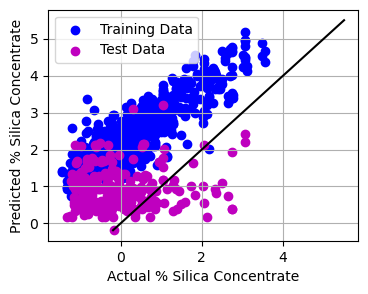

RF
  Best cross-validation score (R2) : 0.69061
  Best cross-validation score (MSE): 0.29722
  Best cross-validation score (MAE): 1.92882
  Performance on train data (R2) :  0.95792
  Performance on train data (MSE):  0.04208
  Performance on train data (MAE):  0.14770
  Performance on test data (R2)  :  -0.13060
  Performance on test data (MSE) :  0.93569
  Performance on test data (MAE) :  0.69059
  Performance on all data (R2)   :  0.91565
  Performance on all data (MSE)  :  0.08154
  Performance on all data (MAE)  :  0.19121


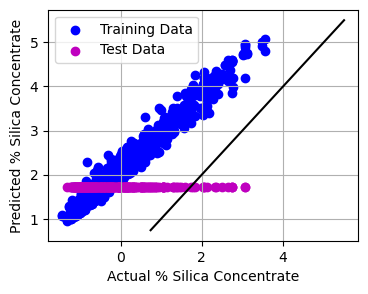

GBR
  Best cross-validation score (R2) : 0.69393
  Best cross-validation score (MSE): 0.29290
  Best cross-validation score (MAE): 1.99198
  Performance on train data (R2) :  0.93330
  Performance on train data (MSE):  0.06670
  Performance on train data (MAE):  0.18850
  Performance on test data (R2)  :  -0.26883
  Performance on test data (MSE) :  1.05009
  Performance on test data (MAE) :  0.71778
  Performance on all data (R2)   :  0.89750
  Performance on all data (MSE)  :  0.09908
  Performance on all data (MAE)  :  0.22396


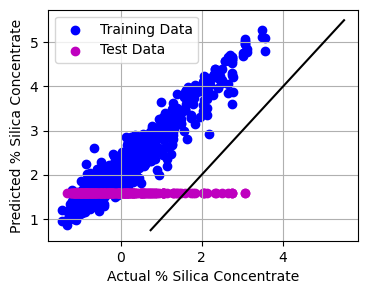

LR
  Best cross-validation score (R2) : 0.60808
  Best cross-validation score (MSE): 0.37980
  Best cross-validation score (MAE): 2.22785
  Performance on train data (R2) :  0.63788
  Performance on train data (MSE):  0.36212
  Performance on train data (MAE):  0.46359
  Performance on test data (R2)  :  -55945.42598
  Performance on test data (MSE) :  46301.62331
  Performance on test data (MAE) :  209.84818
  Performance on all data (R2)   :  0.63120
  Performance on all data (MSE)  :  0.35651
  Performance on all data (MAE)  :  0.46260


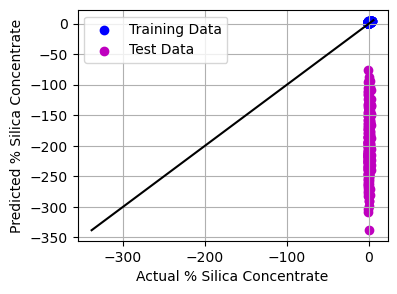

In [8]:
def compute_mse(X, y):
    scores_mse = cross_val_score(best_model, 
                                 X, y.ravel(), 
                                 cv=10, 
                                 scoring='neg_mean_squared_error')
    return -np.mean(scores_mse)


def compute_mae(X, y):
    scores_mae = cross_val_score(best_model, 
                                 X, y.ravel(), 
                                 cv=10, 
                                 scoring='neg_mean_absolute_percentage_error')
    return -np.mean(scores_mae)



def compute_r2(X, y):
    scores_r2 = cross_val_score(best_model, 
                                X, y.ravel(), 
                                cv=10, 
                                scoring='r2')
    return np.mean(scores_r2)

mdl_names = ['MLP','RF', 'GBR','LR']
i = 0
plt.figure(figsize=(15,10))

for best_model in best_mdls:
    best_model.fit(X_train_scaled, y_train_scaled.ravel())  
    print(f"{mdl_names[i]}")
    print("  Best cross-validation score (R2) : %.5f" % compute_r2(X_train_scaled, y_train_scaled.ravel()))
    print("  Best cross-validation score (MSE): %.5f" % compute_mse(X_train_scaled, y_train_scaled.ravel()))
    print("  Best cross-validation score (MAE): %.5f" % compute_mae(X_train_scaled, y_train_scaled.ravel()))
    y_train_pred = best_model.predict(X_train_scaled) 
    R2_train = r2_score(y_train_scaled,y_train_pred.ravel())
    print("  Performance on train data (R2) :  %.5f" % R2_train)
    mse_train = mean_squared_error(y_train_scaled,y_train_pred.ravel())
    print("  Performance on train data (MSE):  %.5f" % mse_train)
    mae_train = mean_absolute_error(y_train_scaled,y_train_pred.ravel())
    print("  Performance on train data (MAE):  %.5f" % mae_train)
    y_test_pred = best_model.predict(X_test)
    R2_test = r2_score(y_test_scaled,y_test_pred.ravel())
    print("  Performance on test data (R2)  :  %.5f" % R2_test)
    mse_test = mean_squared_error(y_test_scaled,y_test_pred.ravel())
    print("  Performance on test data (MSE) :  %.5f" % mse_test)
    mae_test = mean_absolute_error(y_test_scaled,y_test_pred.ravel())
    print("  Performance on test data (MAE) :  %.5f" % mae_test)
    
    X = np.vstack((X_train_scaled, X_test_scaled))
    y = np.vstack((y_train_scaled, y_test_scaled))
    y_pred = best_model.predict(X)
    R2_all = r2_score(y, y_pred)
    print("  Performance on all data (R2)   :  %.5f" % R2_all)
    mse_all = mean_squared_error(y, y_pred)
    print("  Performance on all data (MSE)  :  %.5f" % mse_all)
    mae_all = mean_absolute_error(y, y_pred)
    print("  Performance on all data (MAE)  :  %.5f" % mae_all)
        

    y_train_pred =scaler_Y.inverse_transform(y_train_pred.reshape(-1,1))
    y_test_pred = scaler_Y.inverse_transform(y_test_pred.reshape(-1,1))
    
    

    y_lim = np.vstack((y_train, y_test, 
                       y_train_pred.reshape(-1,1), 
                       y_test_pred.reshape(-1,1)))
    plt.figure(figsize=(4,3))
    plt.plot(np.array([np.min(y_lim), np.max(y_lim)]),
             np.array([np.min(y_lim), np.max(y_lim)]), 'k')
    plt.scatter(y_train_scaled, y_train_pred, color='b', label='Training Data')
    plt.scatter(y_test_scaled, y_test_pred, color='m', label='Test Data')
    plt.xlabel('Actual % Silica Concentrate')
    plt.ylabel('Predicted % Silica Concentrate')
    plt.legend()
    plt.grid()
    plt.show()
    
    
    i += 1


# Explainability analysis 

Using 1046 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


MLP


PermutationExplainer explainer: 1047it [14:18,  1.21it/s]                          


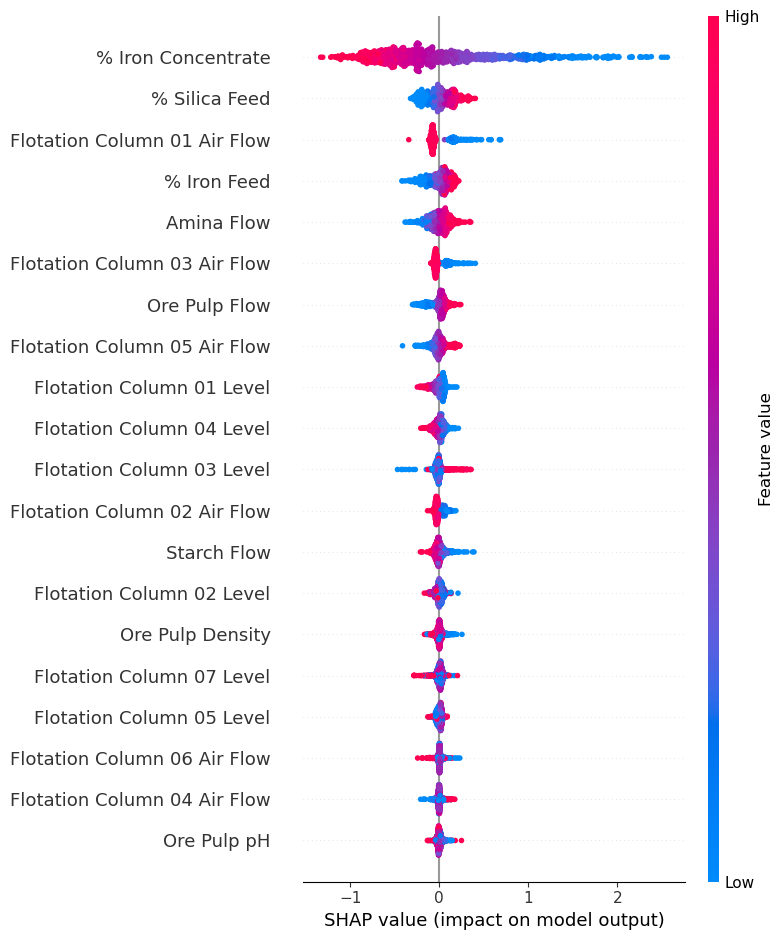

Using 1046 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


RF


PermutationExplainer explainer: 1047it [4:44:46, 16.33s/it]                           


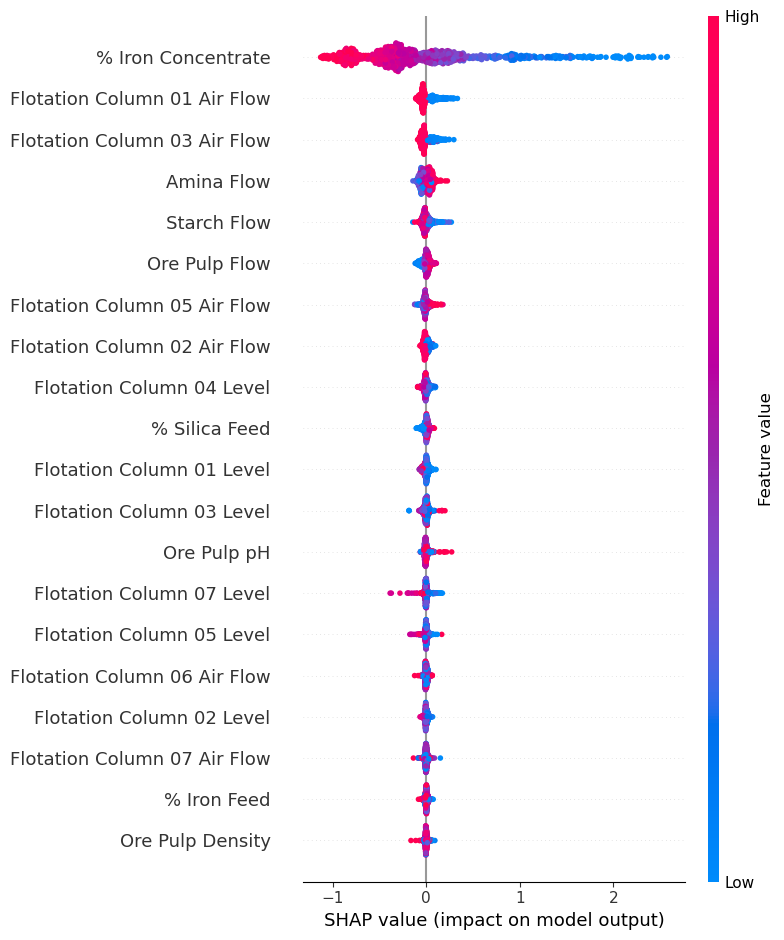

Using 1046 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


GBR


PermutationExplainer explainer: 1047it [33:11,  1.91s/it]                          


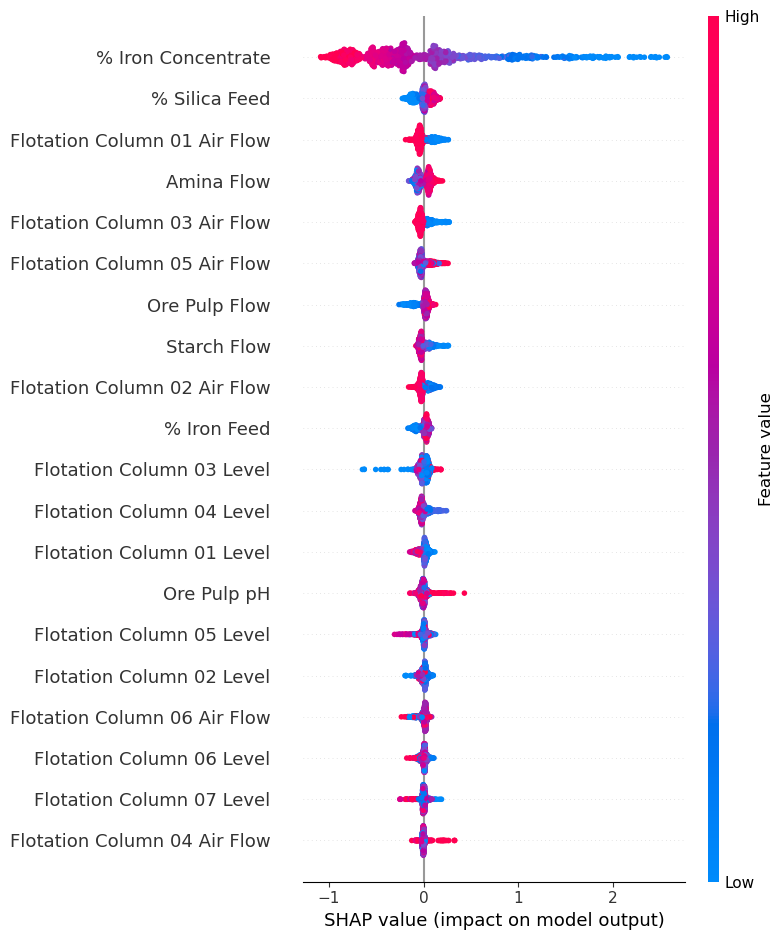

Using 1046 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


LR


PermutationExplainer explainer: 1047it [02:57,  5.58it/s]                          


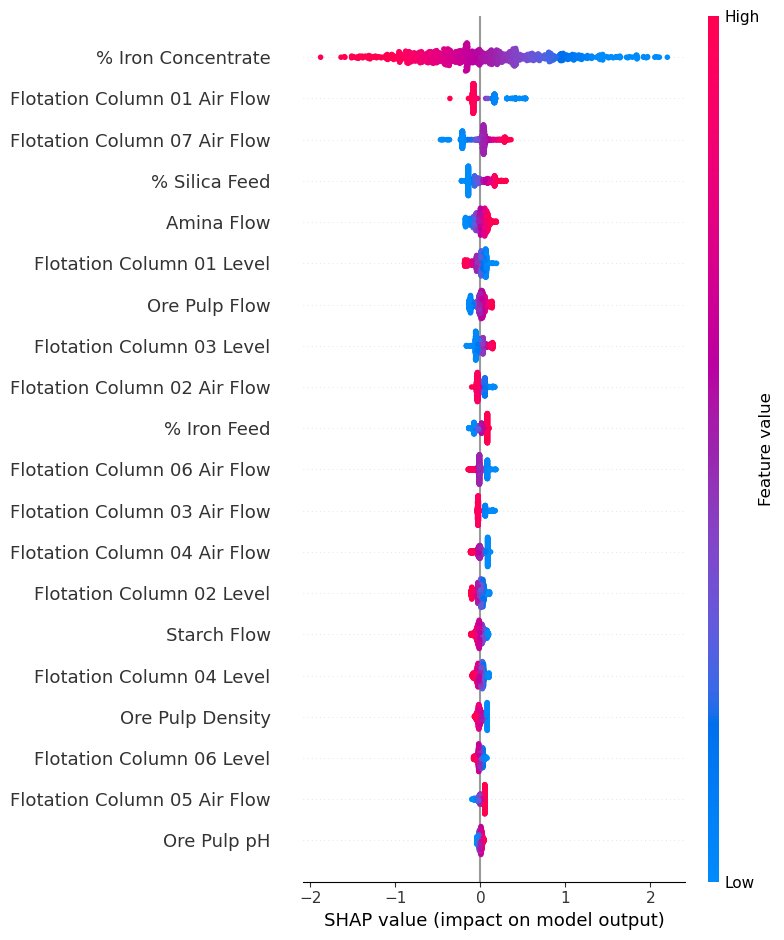

In [9]:
#Using kernel Explainer

import shap

mdl_names = ['MLP','RF', 'GBR','LR']
i = 0
plt.figure(figsize=(15,10))

for best_model in best_mdls:
    print(f"{mdl_names[i]}")
    shap_values = shap.KernelExplainer(best_model.predict, X_train_scaled)
    background = shap.maskers.Independent(X_train_scaled, max_samples=1500)
    explainer = shap.Explainer(best_model.predict, background)
    shap_values = explainer(X_train_scaled)

    # Plot the feature importance using SHAP
    shap.summary_plot(shap_values, X_train_scaled, feature_names= df_filtered.columns.values[0:22])
    i += 1